# Speed Dating Match Prediction

# Task 1: Meme Competition

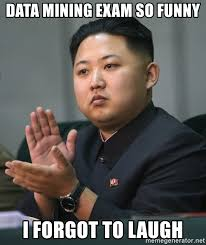

# Task 2: Understand the Template

In [52]:
import pandas as pd # importing pandas
import numpy as np  # import numpy 
from sklearn.linear_model import LogisticRegression # import LogisticRegression model
from sklearn.metrics import f1_score # import evaluation metric
from pprint import pprint  #  import pprint

In [53]:
from google.colab import drive # connet to google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [54]:
data = pd.read_csv('/content/drive/MyDrive/train.csv') # read traning data
data_test = pd.read_csv('/content/drive/MyDrive/test.csv') # read testing data
data.shape # check the dimensions of the training data

(5909, 192)

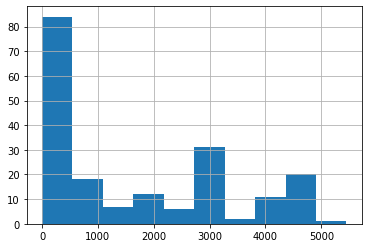

In [55]:
data.isnull().sum().hist() # check the number of null values in that bin

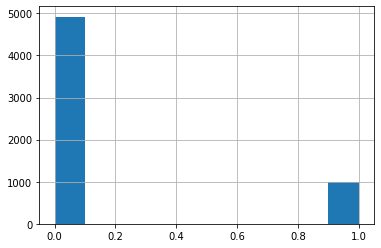

In [56]:
# check the distribution of 'match' attribute
data['match'].hist()

In [57]:
# if you haven't installed xgboost on your system, uncomment the line below
# !pip install xgboost
# if you haven't installed bayesian-optimization on your system, uncomment the line below
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [58]:
x = data.drop('match', axis=1)  # removing 'match' features from training data
features_numeric = list(x.select_dtypes(include=['float64'])) # get list of all numeric attributes
features_categorical = list(x.select_dtypes(include=['object']))# get list of all categorical
y = data['match'] # create label for the training data

In [59]:
print(features_categorical) # printing the list of categories

['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income', 'career']


In [60]:
import numpy as np
from sklearn.compose import ColumnTransformer # import ColumnTransformer
from sklearn.datasets import fetch_openml # fetches datasets from openml 
from sklearn.pipeline import Pipeline # import  pipeline  for assemble several steps and  cross-validation
from sklearn.impute import SimpleImputer # import SimpleImputer for  replace missing values
from sklearn.preprocessing import StandardScaler, OneHotEncoder  # import standard scaler and OneHotEncoder
from sklearn.linear_model import LogisticRegression # import LogisticRegression model
from sklearn.model_selection import train_test_split, GridSearchCV # import data spliter; GridSearchCV
from xgboost.sklearn import XGBClassifier # import XGBoost classifier 

np.random.seed(0) # set random seed 

# apply transformerr to numeric values
transformer_numeric = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),# replace the missing values with  median
        ('scaler', StandardScaler())] # convert feature to one scale
)

# apply transformerr to categorical values
transformer_categorical = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')), # replace missing values with 'missing'
        ('onehot', OneHotEncoder(handle_unknown='ignore')) # one-hot encodes features and handle unknown category 
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', transformer_numeric, features_numeric), # apply numeric transformer to numeric features
        ('cat', transformer_categorical, features_categorical) # apply categorical transformer to numeric features
    ]
)

# assemble the pipiline
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # using preprocessing transformer for the pipeline
        ('my_classifier', XGBClassifier(  
            objective='binary:logistic', seed=1)) #  using XGBClassifier for the pipeline
    ]
)


# hyperparameter used for GridSearch
param_grid = {
    'preprocessor__num__imputer__strategy': ['mean'], # overwriting imputer strategy  
    'my_classifier__n_estimators': [10, 20, 100],  # n_estimators for random forest
    'my_classifier__max_depth':[10, 20] # max_depth for random forest
}


In [61]:
# search across parameter grid utilising the random forest, graded using ROC AUC
grid_search = GridSearchCV(
    full_pipline, param_grid, cv=5, verbose=3, n_jobs=2, 
    scoring='roc_auc')
# fit in the data
grid_search.fit(x, y)

print('best score {}'.format(grid_search.best_score_)) #  best score from grid search
print('best score {}'.format(grid_search.best_params_)) # best hyperparameters from grid search

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best score 0.8789401909943632
best score {'my_classifier__max_depth': 10, 'my_classifier__n_estimators': 100, 'preprocessor__num__imputer__strategy': 'mean'}


In [62]:
# prepare submission:
submission = pd.DataFrame() # initialising df for submission score recording
submission['id'] = data_test['id'] #sampling 'id' for the testing predictions
submission['match'] = grid_search.predict_proba(data_test)[:,1] #sampling 'match' for the testing predictions
submission.to_csv('sample_submission_walkthrough.csv', index=False) # generate csv
submission # printing results

,id,match
0,934,0.007751
1,6539,0.698081
2,6757,0.072405
3,2275,0.008085
4,1052,0.005422
...,...,...
2464,7982,0.088973
2465,7299,0.307890
2466,1818,0.013957
2467,937,0.005086


In [63]:
from skopt import BayesSearchCV # import bayesian optimization
from skopt.space import Real, Categorical, Integer # facilitating search space dimensions for integer, category, and floating data
from sklearn.svm import SVC # import support vector classifier 

# pipeline for SVC
SVC_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor),  # preprocessing pipeline
        ('my_svc', SVC(class_weight='balanced')) # use SVC with balanced class weights
    ]
)



In [64]:
# define search ranges for bayes 
bayes_search = BayesSearchCV(
    SVC_pipline, # Use SVC pipeline for Bayesian Optimization
    {
        'my_svc__C': Real(1e-6, 1e+6, prior='log-uniform'), # search range and randomly sampled using log-uniform
        'my_svc__gamma': Real(1e-6, 1e+1, prior='log-uniform'), # search range for kernel coefficient gamma
        'my_svc__degree': Integer(1,8), # search  range for degree of different polynomial classifiers
        'my_svc__kernel': Categorical(['linear', 'poly', 'rbf']),  # search with different kernel types 
    },
    n_iter=1, # the number of iterations
    random_state=0, # random seed
    verbose=3, # verbosity determines the amount of printed information.
)

bayes_search.fit(x, y) # run bayes search for 1 iteration

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly;, score=0.830 total time=  11.0s
[CV 2/5] END my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly;, score=0.812 total time=  12.1s
[CV 3/5] END my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly;, score=0.818 total time=   8.0s
[CV 4/5] END my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly;, score=0.821 total time=  12.1s
[CV 5/5] END my_svc__C=2.352718564818733, my_svc__degree=6, my_svc__gamma=0.022854318128961743, my_svc__kernel=poly;, score=0.832 total time=  10.3s


BayesSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('imputer',
                                                                                           SimpleImputer(strategy='median')),
                                                                                          ('scaler',
                                                                                           StandardScaler())]),
                                                                          ['positin1',
                                                                           'pid',
                                                                           'int_corr',
                                                                           'age_o',
                                                                           'race_

In [65]:
print('best score {}'.format(bayes_search.best_score_)) # best score from bayesian optimization 
print('best score {}'.format(bayes_search.best_params_)) # best hyperparameters

best score 0.8228142716531203
best score OrderedDict([('my_svc__C', 2.352718564818733), ('my_svc__degree', 6), ('my_svc__gamma', 0.022854318128961743), ('my_svc__kernel', 'poly')])


In [66]:
print('all the cv scores')
pprint(bayes_search.cv_results_) # printing results after performing bayesian optimization

all the cv scores
{'mean_fit_time': array([9.52343507]),
 'mean_score_time': array([1.17750573]),
 'mean_test_score': array([0.82281427]),
 'param_my_svc__C': masked_array(data=[2.352718564818733],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_my_svc__degree': masked_array(data=[6],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_my_svc__gamma': masked_array(data=[0.022854318128961743],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_my_svc__kernel': masked_array(data=['poly'],
             mask=[False],
       fill_value='?',
            dtype=object),
 'params': [OrderedDict([('my_svc__C', 2.352718564818733),
                         ('my_svc__degree', 6),
                         ('my_svc__gamma', 0.022854318128961743),
                         ('my_svc__kernel', 'poly')])],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.82994924]),
 'split1_t

# Task 3 Problem Formulation

**Define the problem. What is the input? What is the output? What data mining function is required? What could be the challenges? What is the impact? What is an ideal solution?**

the machine learning model intakes both numeric and categorical data and output classification prediction. As the data has several missing values. preprocessing techniques are necessary, before feeding data.  preprocessing and  classification functions us required for this data mining problem. In order to accelerate the data mining process, pipelines from the scikit-learn API were used to execute steps sequentially. I consider hyperparameter tuning to be the most difficult aspect since it consumes so much time. A decent set of hyperparameters may considerably improve the performance of the modal. 
alternatively, we might use an automated search method to discover the optimal model parameters.

#Task 4 Tuning the Classifier models

## Trial 1-2 

From previous traning result we can see, XGBClassifier achieved 0.8789 accuracy and SVM achieved 0.8228 accuracy.  for the first trial, i plan to use different search algrithm to tuning SVM  see if the accuracy getting better.



In [67]:
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV #import train_test_split, GridSearchCV


In [68]:
# difine assembled pipeline 
full_pipline2 = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # complete preprocessing transformer
        ('my_svc', SVC(class_weight='balanced')) #  using XGBClassifier for the pipeline
    ]
)


param_grid2 = {
        'my_svc__degree': [1,8], # sampling range for degree of different polynomial classifiers
        'my_svc__kernel':['linear', 'poly', 'rbf'], # different kernel types to try
}

In [69]:
# search across parameter grid utilising GridSearch, graded using ROC AUC
grid_search2 = GridSearchCV(SVC_pipline, param_grid2, cv=5,verbose=3, n_jobs=2, scoring='roc_auc')
# fit in the data
grid_search2.fit(x, y)

print('best score {}'.format(grid_search2.best_score_)) #  best score from grid search
print('best score {}'.format(grid_search2.best_params_)) # best hyperparameters from grid search

Fitting 5 folds for each of 6 candidates, totalling 30 fits
best score 0.8634851228104019
best score {'my_svc__degree': 1, 'my_svc__kernel': 'poly'}


In [70]:
from sklearn.model_selection import RandomizedSearchCV #import RandomizedSearch

In [71]:
# search across parameter grid utilising RandomizedSearch, graded using ROC AUC
rdm2 = RandomizedSearchCV(SVC_pipline, param_grid2,cv=5,n_iter=5, verbose=3, n_jobs=2, scoring='roc_auc' )
 
rdm2.fit(x, y)# fit in the data
print('best score {}'.format(rdm2.best_score_))#  best score from grid search
print('best params {}'.format(rdm2.best_params_))# best hyperparameters from grid search

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best score 0.8526820877758695
best params {'my_svc__kernel': 'rbf', 'my_svc__degree': 1}


## Trial 3-4

it seem like SVM still not better than XGBoost classifier  after i use RandomizedSearchCV and BayesSearch for tuning the model.  in this trial, i try to use different search algrithm for tuning  XGBoost classifier

In [72]:
from sklearn.model_selection import RandomizedSearchCV #import RandomizedSearch

In [73]:
# search across parameter grid utilising RandomizedSearch, graded using ROC AUC
rdm3 = RandomizedSearchCV(full_pipline, param_grid,cv=5,n_iter=5, verbose=3, n_jobs=2, scoring='roc_auc')
 
rdm3.fit(x, y)# fit in the data
print('best score {}'.format(rdm3.best_score_))#  best score from grid search
print('best params {}'.format(rdm3.best_params_))# best hyperparameters from grid search

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best score 0.8789401909943632
best params {'preprocessor__num__imputer__strategy': 'mean', 'my_classifier__n_estimators': 100, 'my_classifier__max_depth': 10}


In [74]:
from skopt import BayesSearchCV # import bayesian optimization
from skopt.space import Real, Categorical, Integer # facilitating search space dimensions for integer, category, and floating data

In [75]:
# assembled pipeline for XGBClassifier
full_pipline = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # apply preprocessing transformer
        ('my_classifier', XGBClassifier(  
            objective='binary:logistic', seed=0)) #  using XGBClassifier for the pipeline
    ]
)

In [102]:
# define the search range for XGBClassifier
xgb_params_bayes = {
 'preprocessor__num__imputer__strategy': Categorical(['mean']), #imputer _strategy
 'my_classifier__n_estimators': Integer(50,1000), #n_estimators
 'my_classifier__max_depth': Integer(5,10), #max depth
 'my_classifier__learning_rate':Real(0.01,0.2,prior='log-uniform') # learning rate
}


In [103]:
# search across parameter grid utilising BayesSearch, graded using ROC AUC
bys3 = BayesSearchCV(full_pipline, xgb_params_bayes, cv=5,n_iter=5, verbose=3, n_jobs=2,scoring='roc_auc')
#fit in the data
bys3.fit(x, y)
print('best score {}'.format(bys3.best_score_))#  best score from grid search
print('best params {}'.format(bys3.best_params_))# best hyperparameters from grid search

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
best score 0.8806206347859027
best params OrderedDict([('my_classifier__learning_rate', 0.02927655230248249), ('my_classifier__max_depth', 5), ('my_classifier__n_estimators', 224), ('preprocessor__num__imputer__strategy', 'mean')])


## Trial 5-6 RandomForestClassifier 

try to use different classifier see if the model could have a better performace.  So,i use  RandomForestClassifier  and tuning it with GridSearch, RandomizedSearch, and BayesSearch

In [78]:
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier

In [79]:
# define assembled pipeline 
full_pipline1 = Pipeline(
    steps=[
        ('preprocessor', preprocessor), # apply preprocessing transformer
        ('rf', RandomForestClassifier(  
            random_state=0)) #  using XGBClassifier for the pipeline
    ]
)

# define search ranges
param_grid1 = {
    'preprocessor__num__imputer__strategy': ['mean'], # overwriting imputer strategy for numeric transformer 
    'rf__n_estimators': [10, 30, 100],  # n_estimators for random forest
    'rf__max_depth':[10, 20], # max_depth for random forest
     'rf__criterion':['gini','entropy'], #criterion
}


In [80]:
# search across parameter grid utilising GridSearch, graded using ROC AUC
grid_search5 = GridSearchCV(full_pipline1, param_grid1, cv=5,verbose=3, n_jobs=2, scoring='roc_auc')
# fit in the data
grid_search5.fit(x, y)

print('best score {}'.format(grid_search5.best_score_)) #  best score from grid search
print('best score {}'.format(grid_search5.best_params_)) # best hyperparameters from grid search

Fitting 5 folds for each of 12 candidates, totalling 60 fits
best score 0.8520907406020333
best score {'preprocessor__num__imputer__strategy': 'mean', 'rf__criterion': 'entropy', 'rf__max_depth': 10, 'rf__n_estimators': 100}


In [81]:
# search across parameter grid utilising RandomizedSearch, graded using ROC AUC
rdm5 = RandomizedSearchCV(full_pipline1, param_grid1,cv=5,n_iter=5, verbose=3, n_jobs=2, scoring='roc_auc')
 # fit in the data
rdm5.fit(x, y)
print('best score {}'.format(rdm5.best_score_))#  best score from grid search
print('best params {}'.format(rdm5.best_params_))# best hyperparameters from grid search

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best score 0.8473334786175346
best params {'rf__n_estimators': 100, 'rf__max_depth': 10, 'rf__criterion': 'gini', 'preprocessor__num__imputer__strategy': 'mean'}


In [82]:
  # # search across parameter grid utilising BayesSearch, graded using ROC AUC
  # bys = BayesSearchCV(full_pipline1, param_grid1, cv=5,n_iter=1, verbose=3, n_jobs=2,scoring='roc_auc' )
  #  # fit in the data
  # bys.fit(x, y)
  # print('best score {}'.format(bys.best_score_))#  best score from grid search
  # print('best params {}'.format(bys.best_params_))# best hyperparameters from grid search

## trial 7-8 KNeighborsClassifier

try to use different classifier see if the model could have a better performace.  So,i use  KNeighborsClassifier  and tuning it with GridSearch, RandomizedSearch.

In [83]:
from sklearn.neighbors import KNeighborsClassifier #import KNeighborsClassifier

In [84]:
# define assembled pipeline 
knn_pipeline = Pipeline(
 steps=[
  ('preprocessor', preprocessor),  # apply preprocessing transformer
  ('knn', KNeighborsClassifier()) # using KNeighborsClassifier 
 ]
)

In [85]:
# define search ranges for knn
knn_params = {
 'preprocessor__num__imputer__strategy': ['mean'],
 'knn__n_neighbors': [20,50,80,150],
 'knn__algorithm':['auto', 'ball_tree', 'kd_tree', 'brute'],
 'knn__p':[1,2]
}

In [86]:
# search across parameter grid utilising GridSearch, graded using ROC AUC
grid_search7 = GridSearchCV(knn_pipeline, knn_params, cv=2, verbose=3, n_jobs=2, scoring='roc_auc')
# fit in the data
grid_search7.fit(x, y)

print('best score {}'.format(grid_search7.best_score_)) #  best score from grid search
print('best score {}'.format(grid_search7.best_params_)) # best hyperparameters from grid search

Fitting 2 folds for each of 32 candidates, totalling 64 fits
best score 0.8226258230983909
best score {'knn__algorithm': 'auto', 'knn__n_neighbors': 150, 'knn__p': 2, 'preprocessor__num__imputer__strategy': 'mean'}


In [87]:
# search across parameter grid utilising RandomizedSearch, graded using ROC AUC
rdm7 = RandomizedSearchCV( knn_pipeline, knn_params,cv=5,n_iter=5, verbose=3, n_jobs=2, scoring='roc_auc' )
 #fit in the data
rdm7.fit(x, y)
print('best score {}'.format(rdm7.best_score_))#  best score from grid search
print('best params {}'.format(rdm7.best_params_))# best hyperparameters from grid search

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best score 0.8253817133003285
best params {'preprocessor__num__imputer__strategy': 'mean', 'knn__p': 2, 'knn__n_neighbors': 150, 'knn__algorithm': 'ball_tree'}


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_base.py:504: UserWarning: cannot use tree with sparse input: using brute force
  warnings.warn("cannot use tree with sparse input: using brute force")


In [88]:
#  # search across parameter grid utilising BayesSearchCV, graded using ROC AUC
#   bys = BayesSearchCV(knn_pipeline, knn_params, cv=5,n_iter=5, verbose=3, n_jobs=2,scoring='roc_auc')
#    #fit in the data
#   bys.fit(x, y)
#   print('best score {}'.format(bys.best_score_)) #  best score from grid search
#   print('best params {}'.format(bys.best_params_))# best hyperparameters from grid search

## trial 9-10 DecisionTreeClassifier

try to use different classifier see if the model could have a better performace.  So,i use  DecisionTreeClassifier  and tuning it with GridSearch, RandomizedSearch

In [89]:
from sklearn.tree import DecisionTreeClassifier # import DecisionTreeClassifier

In [90]:
# define assembled pipeline 
dt_pipeline = Pipeline(
 steps=[
  ('preprocessor', preprocessor), # apply preprocessor transformer
  ('dt', DecisionTreeClassifier(random_state=0)) # apply DecisionTreeClassifier
 ]
)

In [91]:
# define search grid for DecisionTreeClassifier
dt_params = {
 'preprocessor__num__imputer__strategy': ['mean'], # imputer strategy
 'dt__criterion': ['gini','entropy'],# criterion
 'dt__splitter': ['best','random'],# splitter
 'dt__max_depth': [5,10,15,20],# max_depth
 'dt__min_samples_leaf': [1,2,3,5,10],# min samples per leaf
}

In [92]:
# search across parameter grid utilising GridSearch, graded using ROC AUC
grid_search9 = GridSearchCV(dt_pipeline, dt_params, cv=5,verbose=3, n_jobs=2, scoring='roc_auc')
# fit in the data
grid_search9.fit(x, y)

print('best score {}'.format(grid_search9.best_score_)) #  best score from grid search
print('best score {}'.format(grid_search9.best_params_)) # best hyperparameters from grid search

Fitting 5 folds for each of 80 candidates, totalling 400 fits
best score 0.8163030606171254
best score {'dt__criterion': 'entropy', 'dt__max_depth': 5, 'dt__min_samples_leaf': 5, 'dt__splitter': 'best', 'preprocessor__num__imputer__strategy': 'mean'}


In [93]:
# search across parameter grid utilising RandomizedSearchCV, graded using ROC AUC
rdm9 = RandomizedSearchCV( dt_pipeline, dt_params,cv=5,n_iter=5, verbose=3, n_jobs=2, scoring='roc_auc' )
 
rdm9.fit(x, y)
print('best score {}'.format(rdm9.best_score_))#  best score from grid search
print('best params {}'.format(rdm9.best_params_))# best hyperparameters from grid search

Fitting 5 folds for each of 5 candidates, totalling 25 fits
best score 0.797831715783309
best params {'preprocessor__num__imputer__strategy': 'mean', 'dt__splitter': 'random', 'dt__min_samples_leaf': 3, 'dt__max_depth': 5, 'dt__criterion': 'entropy'}


In [94]:
  # # search across parameter grid utilising BayesSearch, graded using ROC AUC
  # bys = BayesSearchCV(dt_pipeline, dt_params, cv=5,n_iter=5, verbose=3, n_jobs=2,scoring='roc_auc')
  # # fit in the data
  # bys.fit(x, y)
  # print('best score {}'.format(bys.best_score_)) #  best score from grid search
  # print('best params {}'.format(bys.best_params_))# best hyperparameters from grid search

# Task 5 prepare the CSV for submision

submision

In [95]:
pd.DataFrame(bys3.cv_results_) # printing results after performing bayesian optimization

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_my_classifier__learning_rate,param_my_classifier__max_depth,param_my_classifier__n_estimators,param_preprocessor__num__imputer__strategy,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,86.279165,13.210893,0.247217,0.034990,0.029089,8,998,mean,{'my_classifier__learning_rate': 0.02908866208...,0.885300,0.889741,0.875493,0.862795,0.878647,0.878395,0.009255,5
1,99.561970,15.435218,0.266820,0.035342,0.016659,9,984,mean,{'my_classifier__learning_rate': 0.01665939954...,0.887011,0.890824,0.878275,0.866187,0.882635,0.880986,0.008511,1
2,64.767958,9.831641,0.205927,0.028960,0.041224,7,885,mean,{'my_classifier__learning_rate': 0.04122363564...,0.888248,0.889864,0.874338,0.865587,0.885147,0.880637,0.009269,3
3,31.298721,5.248231,0.148023,0.022269,0.032506,6,510,mean,{'my_classifier__learning_rate': 0.03250602925...,0.885717,0.891773,0.873799,0.868964,0.884038,0.880858,0.008297,2
4,69.338733,11.131618,0.222986,0.030423,0.01065,7,957,mean,{'my_classifier__learning_rate': 0.01064965221...,0.882563,0.893785,0.873404,0.868738,0.884069,0.880512,0.008743,4


In [96]:
submission = pd.DataFrame() # initializing df for recording submission scores
submission['id'] = data_test['id'] # Series of samples for which predictions are being made
submission['match'] = bys3.predict_proba(data_test)[:,1] # use grid search to predict probability for each sample in test split
submission.to_csv('submission_walkthrough.csv', index=False) # generate submission csv for template
submission # printing submission results dataframe

,id,match
0,934,0.008379
1,6539,0.808088
2,6757,0.145475
3,2275,0.013524
4,1052,0.002424
...,...,...
2464,7982,0.064905
2465,7299,0.748216
2466,1818,0.021537
2467,937,0.003530


In [97]:
# from google.colab import files
# files.download("submission_walkthrough.csv") #download the csv

#  Task 6 Answer the questions below

**why a simple linear regression model  is not good for classification task,compared to Perceptron/Logistic regression?**

Simple linear regression can only separate two-dimensional data, and only use a line as a decision boundary.This is insufficient for higher-dimensional data, requiring a more complex classifier.

**What's a decision tree and how it is different to a logistic regression model?**

Logistic Regression presupposes that the data is separable in space linearly (or curving linearly). Decision Trees are non-linear classifiers that do not require linearly separable data.

**What's the difference between grid search and random search?**

Grid Search performs a thorough search for each hyperparameter combination. Random search will sample combinations at random based on the iteration setting; not all values are tried, and the combinations tested are selected at random.

**What's the difference between bayesian search and random search?**

Bayesian optimization employs the previous iteration's result to determine the next hyperparameter value candidates. The main difference between Bayesian optimization and grid/random search is that grid and random search examine each hyperparameter combination independently, whereas Bayesian optimization relies on prior evaluation.

# Task 7 submit the csv to the leaderboards

I used XGBClassifier in collaboration with BayesSearch to automatically tune the hyperparameters for 5 iterations. The model with the optimal parameters achieved an accuracy of 0.88935, outperforming the baseline model.

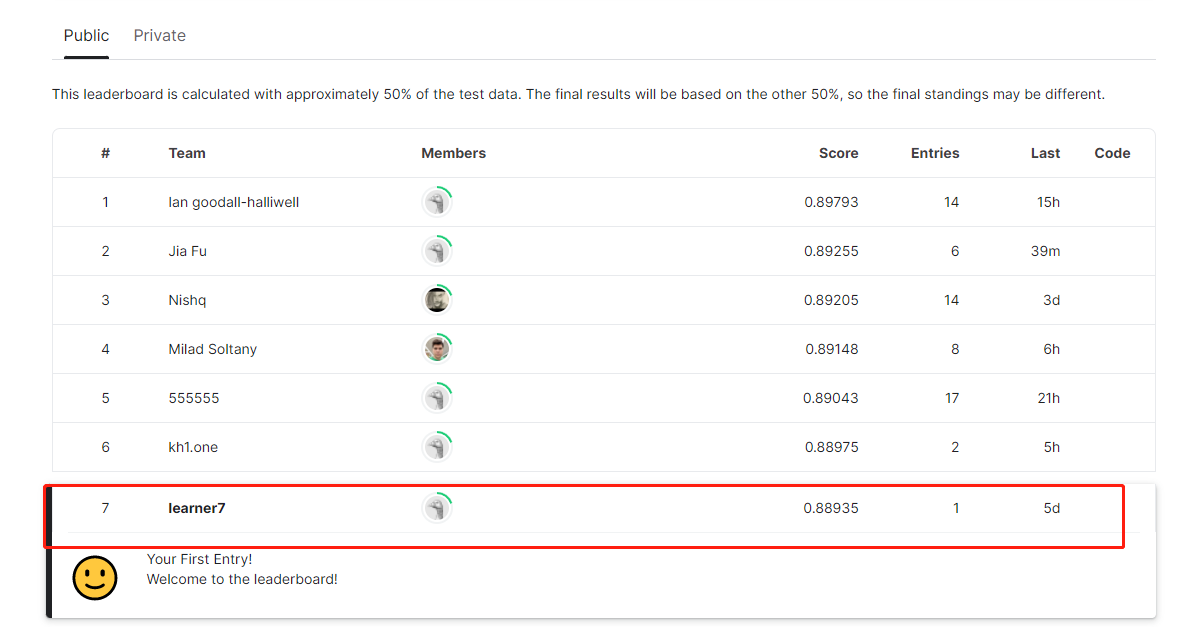